# PyMC and PyTensor
Authors: Ricardo Vieira and Juan Orduz

このノートブックでは、PyMC モデルがどのように PyTensor グラフに変換されるかを紹介したいと思います。 この目的は、```pytensor``` のすべての機能を詳細に説明することではなく、PyMC との関係を理解するために主要な概念に焦点を当てることです。 プロジェクトの詳細については、公式ドキュメントを参照してください。

## Prepare Notebook
まず必要なライブラリをインポートします。

In [2]:
import pytensor
import pytensor.tensor as pt
import pymc as pm
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

## Introduction to PyTensor
まずは ```pytensor```` を調べてみましょう。 彼らの文書によると

> PyTensor は、多次元配列を含む数式を定義、最適化、効率的に評価できる Python ライブラリです。

### A simple example
まず、いくつかの pytensor テンソルを定義し、いくつかの基本的な操作を実行する方法を示します。

In [3]:
x = pt.scalar(name = "x")
y = pt.vector(name = "y")

print(
    f"""
x type: {x.type}
x name = {x.name}
---
y type: {y.type}
y name = {y.name}
"""
)


x type: Scalar(float64, shape=())
x name = x
---
y type: Vector(float64, shape=(?,))
y name = y



```x``` テンソルと ```y``` テンソルを定義したので、それらを加算して新しいテンソルを作成できます。

In [4]:
z = x + y
z.name = "x + y"

計算をもう少し複雑にするために、結果として得られるテンソルの対数を取得してみましょう。

In [5]:
w = pt.log(z)
w.name = "log(x + y)"

```dprint()``` 関数を使用して、指定されたテンソルの計算グラフを出力できます。

In [6]:
pytensor.dprint(w)

Log [id A] 'log(x + y)'
 └─ Add [id B] 'x + y'
    ├─ ExpandDims{axis=0} [id C]
    │  └─ x [id D]
    └─ y [id E]


このグラフでは (まだ) 計算が行われていないことに注意してください。 実行するステップの順序を定義するだけです。 [```function()```](https://pytensor.readthedocs.io/en/latest/library/index.html#pytensor.function) を使用して呼び出し可能なオブジェクトを定義し、値をプッシュできます。 グラフを参照してください。

In [7]:
f = pytensor.function(inputs = [x, y], outputs = w)

グラフがコンパイルされたので、いくつかの具体的な値をプッシュできます:

In [8]:
f(x = 0, y = [1, np.e])

array([0., 1.])

````
```Tip
単にデバッグしたい場合もあります。そのためには ``eval()`` を使用できます。
```
````

In [9]:
w.eval({x: 0, y: [1, np.e]})

array([0., 1.])

### PyTensor is clever!
``pytensor```` の最も重要な機能の 1 つは、グラフ内の数学的演算を自動的に最適化できることです。 簡単な例を考えてみましょう

In [10]:
a = pt.scalar(name="a")
b = pt.scalar(name="b")

c = a / b
c.name = "a / b"

pytensor.dprint(c)

True_div [id A] 'a / b'
 ├─ a [id B]
 └─ b [id C]


ここで、``b`` と ``c`` を掛けてみましょう。 これは単に ```a``` という結果になるはずです。

In [11]:
d = b * c
d.name = "b * c"

pytensor.dprint(d)

Mul [id A] 'b * c'
 ├─ b [id B]
 └─ True_div [id C] 'a / b'
    ├─ a [id D]
    └─ b [id B]


グラフは完全な計算を示していますが、それをコンパイルすると、予想どおり、演算は ``a`` 上の恒等になります。

### What is in an PyTensor graph?
次の図は、``pytensor`` グラフの基本構造を示しています。

上のセクションの最初の例でこれらの概念を明示的に示すことで、これらの概念をより具体的にすることができます。 テンソル ```z``` のグラフ成分を計算してみましょう。

In [12]:
print(
    f"""
z type: {z.type}
z name = {z.name}
z owner = {z.owner}
z owner inputs = {z.owner.inputs}
z owner op = {z.owner.op}
z owner output = {z.owner.outputs}
"""
)


z type: Vector(float64, shape=(?,))
z name = x + y
z owner = Add(ExpandDims{axis=0}.0, y)
z owner inputs = [ExpandDims{axis=0}.0, y]
z owner op = Add
z owner output = [x + y]



次のコード スニペットは、``w`` の計算グラフを確認することで、これらの概念を理解するのに役立ちます。 ここでは実際のコードはそれほど重要ではなく、出力に焦点を当てています。

In [13]:
# start from the top
stack = [w]

while stack:
    print("---")
    var = stack.pop(0)
    print(f"Checking variable {var} of type {var.type}")
    # check variable is not a root variable
    if var.owner is not None:
        print(f" > Op is {var.owner.op}")
        # loop over the inputs
        for i, input in enumerate(var.owner.inputs):
            print(f" > Input {i} is {input}")
            stack.append(input)
    else:
        print(f" > {var} is a root variable")

---
Checking variable log(x + y) of type Vector(float64, shape=(?,))
 > Op is Log
 > Input 0 is x + y
---
Checking variable x + y of type Vector(float64, shape=(?,))
 > Op is Add
 > Input 0 is ExpandDims{axis=0}.0
 > Input 1 is y
---
Checking variable ExpandDims{axis=0}.0 of type Vector(float64, shape=(1,))
 > Op is ExpandDims{axis=0}
 > Input 0 is x
---
Checking variable y of type Vector(float64, shape=(?,))
 > y is a root variable
---
Checking variable x of type Scalar(float64, shape=())
 > x is a root variable


これは、上で紹介した ```dprint()``` 関数の出力と非常に似ていることに注意してください。

In [14]:
pytensor.dprint(w)

Log [id A] 'log(x + y)'
 └─ Add [id B] 'x + y'
    ├─ ExpandDims{axis=0} [id C]
    │  └─ x [id D]
    └─ y [id E]


### Graph manipulation 101
PyTensor のもう 1 つの興味深い機能は、計算グラフを操作できることですが、これは TensorFlow や PyTorch では不可能です。 ここでは、この手法に関する主なアイデアを説明するために、上記の例を続けます。

In [15]:
# get input tensors
list(pytensor.graph.graph_inputs(graphs = [w]))

[x, y]

簡単な例として、```log()``` の前に ```exp()``` を追加してみましょう (恒等関数を取得するため)。

In [16]:
parent_of_w = w.owner.inputs[0]  # get z tensor
new_parent_of_w = pt.exp(parent_of_w)  # modify the parent of w
new_parent_of_w.name = "exp(x + y)"

```w``` のグラフは実際には変化していないことに注意してください。

In [17]:
pytensor.dprint(w)

Log [id A] 'log(x + y)'
 └─ Add [id B] 'x + y'
    ├─ ExpandDims{axis=0} [id C]
    │  └─ x [id D]
    └─ y [id E]


グラフを変更するには、```clone_replace()``` 関数を使用する必要があります。この関数は、対応する置換を含む最初のサブグラフのコピーを返します。

In [18]:
new_w = pytensor.clone_replace(output = [w], replace = {parent_of_w: new_parent_of_w})[0]
new_w.name = "log(exp(x + y))"
pytensor.dprint(new_w)

Log [id A] 'log(exp(x + y))'
 └─ Exp [id B] 'exp(x + y)'
    └─ Add [id C] 'x + y'
       ├─ ExpandDims{axis=0} [id D]
       │  └─ x [id E]
       └─ y [id F]


最後に、新しいグラフに入力を渡すことで、変更されたグラフをテストできます。

In [19]:
new_w.eval({x: 0, y: [1, np.e]})

array([1.        , 2.71828183])

予想どおり、新しいグラフは単なる恒等関数です。

````
```Note
繰り返しますが、```pytensor```` は、関数をコンパイルした後に ```exp``` と ```log``` を省略できるほど賢いことに注意してください。
```
````

In [20]:
f = pytensor.function(inputs=[x, y], outputs=new_w)

pytensor.dprint(f)

Add [id A] 'x + y' 1
 ├─ ExpandDims{axis=0} [id B] 0
 │  └─ x [id C]
 └─ y [id D]


In [21]:
f(x=0, y=[1, np.e])

array([1.        , 2.71828183])

### PyTensor RandomVariables
pytensor の基本を理解したので、確率変数の方向に進みたいと思います。

[```numpy```](https://github.com/numpy/numpy) で乱数を生成するにはどうすればよいですか? これを説明するために、正規分布からサンプリングすることができます。

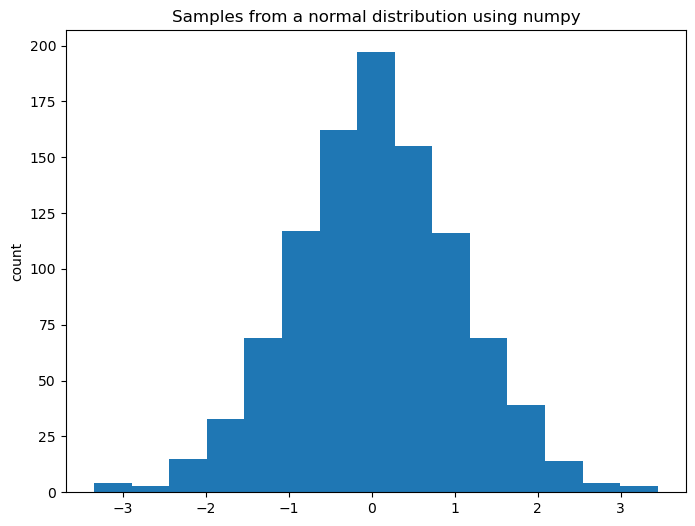

In [22]:
a = np.random.normal(loc=0, scale=1, size=1_000)

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(a, color="C0", bins=15)
ax.set(title = "Samples from a normal distribution using numpy", ylabel="count");

では、PyTensor でそれを実行してみましょう。

In [23]:
y = pt.random.normal(loc = 0, scale = 1, name = "y")
y.type

TensorType(float64, shape=())

次に ``dprint()`` を使ってグラフを表示します。

In [24]:
pytensor.dprint(y)

normal_rv{0, (0, 0), floatX, False}.1 [id A] 'y'
 ├─ RandomGeneratorSharedVariable(<Generator(PCG64) at 0x238E16F73E0>) [id B]
 ├─ [] [id C]
 ├─ 11 [id D]
 ├─ 0 [id E]
 └─ 1 [id F]


入力は常に次の順序になります。

1. rng shared variable
1. size
1. dtype (number code)
1. arg1
1. arg2
1. argn

```eval()``` を呼び出すことでサンプリングできます。 確率変数について。

In [25]:
y.eval()

array(-0.48900026)

ただし、これらのサンプルは常に同じであることに注意してください。

In [26]:
for i in range(10):
    print(f"Sample {i}: {y.eval()}")

Sample 0: -0.48900026215456927
Sample 1: -0.48900026215456927
Sample 2: -0.48900026215456927
Sample 3: -0.48900026215456927
Sample 4: -0.48900026215456927
Sample 5: -0.48900026215456927
Sample 6: -0.48900026215456927
Sample 7: -0.48900026215456927
Sample 8: -0.48900026215456927
Sample 9: -0.48900026215456927


いつも同じサンプルが届きます！ これは、グラフのランダム シード ステップ、つまり ```RandomGeneratorSharedVariable``` に関係します (ここでは、この主題については詳しく説明しません)。 以下に ```pymc``` を使用してさまざまなサンプルを生成する方法を示します。

## PyMC
そのためには、```pymc``` 正規分布を定義することから始めます。

In [27]:
x = pm.Normal.dist(mu = 0, sigma = 1)
pytensor.dprint(x)

normal_rv{0, (0, 0), floatX, False}.1 [id A]
 ├─ RandomGeneratorSharedVariable(<Generator(PCG64) at 0x238E1E7B060>) [id B]
 ├─ [] [id C]
 ├─ 11 [id D]
 ├─ 0 [id E]
 └─ 1 [id F]


```x``` は単なる通常の ```ランダム変数`` であり、```rng``` を除いて ```y``` と同じであることに注意してください。

上記のように ```eval()``` を呼び出してサンプルの生成を試みることができます。

In [28]:
for i in range(10):
    print(f"Sample {i}: {x.eval()}")

Sample 0: 0.8232213972965708
Sample 1: 0.8232213972965708
Sample 2: 0.8232213972965708
Sample 3: 0.8232213972965708
Sample 4: 0.8232213972965708
Sample 5: 0.8232213972965708
Sample 6: 0.8232213972965708
Sample 7: 0.8232213972965708
Sample 8: 0.8232213972965708
Sample 9: 0.8232213972965708


前と同様に、すべての反復で同じ値が得られます。 ランダムなサンプルを生成する正しい方法は、```draw()``` を使用することです。

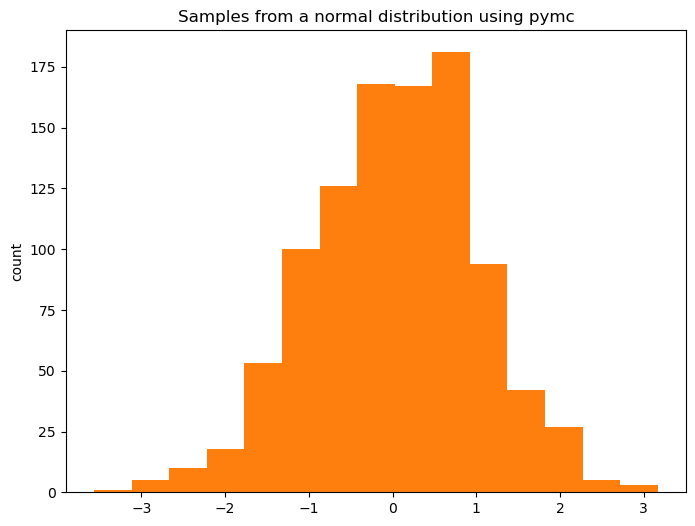

In [29]:
fig, ax = plt.subplots(figsize = (8, 6))
ax.hist(pm.draw(x, draws = 1_000), color = "C1", bins = 15)
ax.set(title="Samples from a normal distribution using pymc", ylabel="count");

わーい！ ````pymc```` ディストリビューションからサンプリングする方法を学びました。

### What is going on behind the scenes?
これが```Model```内でどのように行われるかを見てみましょう。

In [30]:
with pm.Model() as model:
    z = pm.Normal(name="z", mu=np.array([0, 0]), sigma=np.array([1, 2]))

pytensor.dprint(z)

normal_rv{0, (0, 0), floatX, False}.1 [id A] 'z'
 ├─ RandomGeneratorSharedVariable(<Generator(PCG64) at 0x238E229E0A0>) [id B]
 ├─ [] [id C]
 ├─ 11 [id D]
 ├─ [0 0] [id E]
 └─ [1 2] [id F]


前に見たようにランダム変数を作成しているだけですが、今度はそれらを ``pymc`` モデルに登録します。 確率変数のリストを抽出するには、次のようにするだけです:

In [31]:
model.basic_RVs

[z ~ Normal(<constant>, <constant>)]

In [32]:
pytensor.dprint(model.basic_RVs[0])

normal_rv{0, (0, 0), floatX, False}.1 [id A] 'z'
 ├─ RandomGeneratorSharedVariable(<Generator(PCG64) at 0x238E229E0A0>) [id B]
 ├─ [] [id C]
 ├─ 11 [id D]
 ├─ [0 0] [id E]
 └─ [1 2] [id F]


上記のように ```eval()``` を介してサンプリングを試みることができますが、各反復で同じサンプルが得られることは驚くべきことではありません。

In [33]:
for i in range(10):
    print(f"Sample {i}: {z.eval()}")

Sample 0: [0.49097918 0.22042079]
Sample 1: [0.49097918 0.22042079]
Sample 2: [0.49097918 0.22042079]
Sample 3: [0.49097918 0.22042079]
Sample 4: [0.49097918 0.22042079]
Sample 5: [0.49097918 0.22042079]
Sample 6: [0.49097918 0.22042079]
Sample 7: [0.49097918 0.22042079]
Sample 8: [0.49097918 0.22042079]
Sample 9: [0.49097918 0.22042079]


繰り返しますが、サンプリングの正しい方法は ```draw()``` を使用することです。

In [34]:
for i in range(10):
    print(f"Sample {i}: {pm.draw(z)}")

Sample 0: [-2.35504343  0.24653441]
Sample 1: [ 1.38769954 -0.03736549]
Sample 2: [-0.83425029 -0.30935402]
Sample 3: [-0.25626728 -0.67918619]
Sample 4: [0.94461289 2.11103693]
Sample 5: [-0.81395873  0.06716795]
Sample 6: [-0.14677803 -0.57965675]
Sample 7: [0.1860871  2.30573667]
Sample 8: [-0.32586756  0.79006579]
Sample 9: [-2.14798973 -0.17793922]


[Text(0.5, 1.0, 'Samples Histogram')]

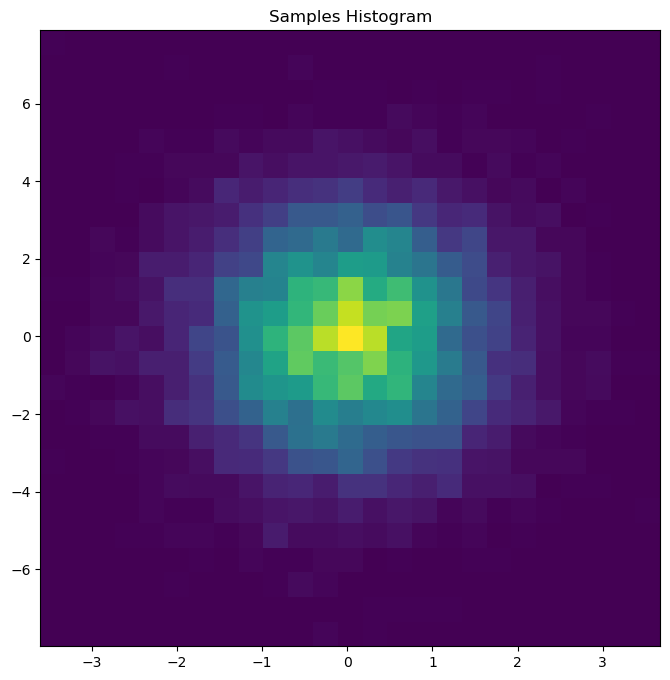

In [35]:
fig, ax = plt.subplots(figsize = (8, 8))
z_draws = pm.draw(vars = z, draws = 10_000)
ax.hist2d(x = z_draws[:, 0], y = z_draws[:, 1], bins = 25)
ax.set(title = "Samples Histogram")

### Enough with Random Variables, I want to see some (log)probabilities!
上記で次のモデルを定義したことを思い出してください:

In [36]:
model

z ~ Normal(<constant>, <constant>)

```pymc``` は ```RandomVariables``` をそれぞれの確率関数に変換できます。 簡単な方法の 1 つは、``logp()`` を使用することです。これは、最初の入力として RandomVariable を受け取り、2 番目の入力として logp が評価される値を受け取ります (これについては後で詳しく説明します)。

In [37]:
z_value = pt.vector(name = "z")
z_logp = pm.logp(rv = z, value = z_value)

```z_logp``` には、```z_value``` で評価された通常の確率変数 ```z``` の対数確率を表す PyTensor グラフが含まれています。

In [38]:
pytensor.dprint(z_logp)

Check{sigma > 0} [id A] 'z_logprob'
 ├─ Sub [id B]
 │  ├─ Sub [id C]
 │  │  ├─ Mul [id D]
 │  │  │  ├─ ExpandDims{axis=0} [id E]
 │  │  │  │  └─ -0.5 [id F]
 │  │  │  └─ Pow [id G]
 │  │  │     ├─ True_div [id H]
 │  │  │     │  ├─ Sub [id I]
 │  │  │     │  │  ├─ z [id J]
 │  │  │     │  │  └─ [0 0] [id K]
 │  │  │     │  └─ [1 2] [id L]
 │  │  │     └─ ExpandDims{axis=0} [id M]
 │  │  │        └─ 2 [id N]
 │  │  └─ ExpandDims{axis=0} [id O]
 │  │     └─ Log [id P]
 │  │        └─ Sqrt [id Q]
 │  │           └─ 6.283185307179586 [id R]
 │  └─ Log [id S]
 │     └─ [1 2] [id L]
 └─ All{axes=None} [id T]
    └─ MakeVector{dtype='bool'} [id U]
       └─ All{axes=None} [id V]
          └─ Gt [id W]
             ├─ [1 2] [id L]
             └─ ExpandDims{axis=0} [id X]
                └─ 0 [id Y]


````
```Tip
確率変数 ``logcdf()`` の対数累積確率を計算するための便利な ``pymc`` 関数もあります。
```
````

冒頭で説明したように、まだ計算が行われていないことに注目してください。 実際の計算は、入力をコンパイルして渡した後に実行されます。 説明のみを目的として、便利な ```eval()``` メソッドを再度使用します。

In [39]:
z_logp.eval({z_value: [0, 0]})

array([-0.91893853, -1.61208571])

これは正規分布の対数確率を評価することに他なりません。

In [40]:
scipy.stats.norm.logpdf(x=np.array([0, 0]), loc=np.array([0, 0]), scale=np.array([1, 2]))

array([-0.91893853, -1.61208571])

```pymc``` モデルは、```RandomVariables``` から確率関数への変換を容易にするいくつかの便利なルーチンを提供します。 たとえば、```logp()``` を使用すると、モデル内のすべての変数の同時確率を抽出できます。

In [41]:
pytensor.dprint(model.logp(sum = False))

Check{sigma > 0} [id A] 'z_logprob'
 ├─ Sub [id B]
 │  ├─ Sub [id C]
 │  │  ├─ Mul [id D]
 │  │  │  ├─ ExpandDims{axis=0} [id E]
 │  │  │  │  └─ -0.5 [id F]
 │  │  │  └─ Pow [id G]
 │  │  │     ├─ True_div [id H]
 │  │  │     │  ├─ Sub [id I]
 │  │  │     │  │  ├─ z [id J]
 │  │  │     │  │  └─ [0 0] [id K]
 │  │  │     │  └─ [1 2] [id L]
 │  │  │     └─ ExpandDims{axis=0} [id M]
 │  │  │        └─ 2 [id N]
 │  │  └─ ExpandDims{axis=0} [id O]
 │  │     └─ Log [id P]
 │  │        └─ Sqrt [id Q]
 │  │           └─ 6.283185307179586 [id R]
 │  └─ Log [id S]
 │     └─ [1 2] [id L]
 └─ All{axes=None} [id T]
    └─ MakeVector{dtype='bool'} [id U]
       └─ All{axes=None} [id V]
          └─ Gt [id W]
             ├─ [1 2] [id L]
             └─ ExpandDims{axis=0} [id X]
                └─ 0 [id Y]


変数は 1 つだけなので、この関数は以前に手動で ``pm.logp`` を呼び出して取得したものと同等です。 ヘルパー ```compile_logp()``` を使用して、モデル logp のコンパイル済みの PyTensor 関数を返すこともできます。

In [42]:
logp_function = model.compile_logp(sum = False)

この関数は、入力として「ポイント」辞書を想定します。 自分で作成することもできますが、もう 1 つの便利な ```Model``` メソッドを説明するために、 ```initial_point()``` を呼び出してみましょう。これは、サンプリングを開始する場所を決定するときにほとんどのサンプラーが使用するポイントを返します。

In [43]:
point = model.initial_point()
point

{'z': array([0., 0.])}

In [44]:
logp_function(point)

[array([-0.91893853, -1.61208571])]

### What are value variables and why are they important?
上で見たように、logp グラフには確率変数がありません。 代わりに、入力 (値) 変数に関して定義されます。 サンプリングする場合、各確率変数 (RV) は、それぞれの入力 (値) 変数で評価される logp 関数に置き換えられます。 いくつかの例を通してこれがどのように機能するかを見てみましょう。 RV 変数と値変数は、次の ```scipy``` 操作で確認できます。

In [45]:
rv = scipy.stats.norm(0, 1)

# Equivalent to rv = pm.Normal("rv", 0, 1)
scipy.stats.norm(0, 1)

In [46]:
# Equivalent to rv_draw = pm.draw(rv, 3)
rv.rvs(3)

array([ 0.04714609,  1.10160755, -0.38712512])

In [47]:
# Equivalent to rv_logp = pm.logp(rv, 1.25)
rv.logpdf(1.25)

-1.7001885332046727

次に、これらの値変数がもう少し複雑なモデルでどのように動作するかを見てみましょう。

In [48]:
with pm.Model() as model_2:
    mu = pm.Normal(name = "mu", mu = 0, sigma = 2)
    sigma = pm.HalfNormal(name = "sigma", sigma = 3)
    x = pm.Normal(name = "x", mu = mu, sigma = sigma)

各モデル RV は「値変数」に関連付けられます

In [49]:
model_2.rvs_to_values

{mu ~ Normal(0, 2): mu,
 sigma ~ HalfNormal(0, 3): sigma_log__,
 x ~ Normal(mu, sigma): x}

実際には、NUTS サンプリングには無制限の値が必要であるため、シグマの場合、関連する値が対数スケールであることに注意してください。

In [50]:
model_2.value_vars

[mu, sigma_log__, x]

モデル変数を抽出する方法がわかったので、特定の値に対するモデルの要素ごとの対数確率を計算できます。

In [51]:
# extract values as pytensor.tensor.var.TensorVariable
mu_value = model_2.rvs_to_values[mu]
sigma_log_value = model_2.rvs_to_values[sigma]
x_value = model_2.rvs_to_values[x]
# element-wise log-probability of the model (we do not take te sum)
logp_graph = pt.stack(model_2.logp(sum=False))
# evaluate by passing concrete values
logp_graph.eval({mu_value: 0, sigma_log_value: -10, x_value: 0})

array([ -1.61208572, -11.32440366,   9.08106147])

これは次と同等です。

In [52]:
print(
    f"""
mu_value -> {scipy.stats.norm.logpdf(x=0, loc=0, scale=2)}
sigma_log_value -> {- 10 + scipy.stats.halfnorm.logpdf(x=np.exp(-10), loc=0, scale=3)} 
x_value -> {scipy.stats.norm.logpdf(x=0, loc=0, scale=np.exp(-10))}
"""
)


mu_value -> -1.612085713764618
sigma_log_value -> -11.324403641427345 
x_value -> 9.081061466795328



````
```Note
```sigma_log_value``` については、ヤコビアンのために ```scipy``` と ```pytensor``` に一致する $-10$ 項を追加します。
```
````

すでに見たように、メソッド ```compile_logp()``` を使用して、モデル logp のコンパイル済み pytensor 関数を取得することもできます。これは、```{値変数名 : 値}``` の辞書を受け取ります。 入力

In [53]:
model_2.compile_logp(sum = False)({"mu": 0, "sigma_log__": -10, "x": 0})

[array(-1.61208572), array(-11.32440366), array(9.08106147)]

```Model``` クラスには、logp の勾配 (```dlogp()```) とヘッセ行列 (```d2logp()```) を抽出するメソッドもあります。

``pytensor`` RandomVariables および ``pymc`` ディストリビューションの内部をさらに詳しく知りたい場合は、ディストリビューション開発者ガイドを参照してください。

In [54]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Wed Apr 03 2024

Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.22.2

pytensor: 2.19.0

pymc      : 5.12.0
numpy     : 1.26.4
pytensor  : 2.19.0
scipy     : 1.12.0
matplotlib: 3.8.3

Watermark: 2.4.3

